In [1]:
import pandas as pd
from IPython.display import display

# 1. data load
df = pd.read_csv('../data/ecommerce.csv', encoding='ISO-8859-1')

# 2. show data
display(df.head())

# 3. check NA
print(df.isna().sum())

# 4. remove rows w/o customer id
df = df[df['CustomerID'].notna()]

# 5. convert data and create revenue column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# 6. detect and delete negative Revenue rows (refunds)
returns_df = df[df['Revenue'] < 0]
sales_df = df[df['Revenue'] > 0]

print(f"Total returns: {returns_df.shape[0]}")
print(f"Total sales: {sales_df.shape[0]}")


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Total returns: 8905
Total sales: 397884


In [2]:
import sqlite3

# create SQLite base in memory
conn = sqlite3.connect(':memory:')
sales_df.to_sql('orders', conn, index=False, if_exists='replace')

# 1. Top 10 products by revenue
query_top_products = """
SELECT Description, SUM(Revenue) as TotalRevenue
FROM orders
GROUP BY Description
ORDER BY TotalRevenue DESC
LIMIT 10;
"""
top_products = pd.read_sql(query_top_products, conn)
display(top_products)

# 2. Top 10 clients by revenue
query_top_customers = """
SELECT CustomerID, SUM(Revenue) as TotalRevenue
FROM orders
GROUP BY CustomerID
ORDER BY TotalRevenue DESC
LIMIT 10;
"""
top_customers = pd.read_sql(query_top_customers, conn)
display(top_customers)

# 3. Revenue by countries
query_revenue_country = """
SELECT Country, SUM(Revenue) as TotalRevenue
FROM orders
GROUP BY Country
ORDER BY TotalRevenue DESC
LIMIT 10;
"""
revenue_country = pd.read_sql(query_revenue_country, conn)
display(revenue_country)

# 4. Monthly revenue dynamics
query_revenue_month = """
SELECT strftime('%Y-%m', InvoiceDate) as Month, SUM(Revenue) as TotalRevenue
FROM orders
GROUP BY Month
ORDER BY Month;
"""
revenue_month = pd.read_sql(query_revenue_month, conn)
display(revenue_month)

#5. # Contribution of top 5 products
top5_share = df.groupby('Description')['Revenue'].sum().nlargest(5).sum() / df['Revenue'].sum() * 100
display(top5_share)

# 6. Average revenue per customer
avg_revenue_customer = df.groupby('CustomerID')['Revenue'].sum().mean()
display(avg_revenue_customer)

,Description,TotalRevenue
0,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,REGENCY CAKESTAND 3 TIER,142592.95
2,WHITE HANGING HEART T-LIGHT HOLDER,100448.15
3,JUMBO BAG RED RETROSPOT,85220.78
4,MEDIUM CERAMIC TOP STORAGE JAR,81416.73
5,POSTAGE,77803.96
6,PARTY BUNTING,68844.33
7,ASSORTED COLOUR BIRD ORNAMENT,56580.34
8,Manual,53779.93
9,RABBIT NIGHT LIGHT,51346.20


,CustomerID,TotalRevenue
0,14646.0,280206.02
1,18102.0,259657.30
2,17450.0,194550.79
3,16446.0,168472.50
4,14911.0,143825.06
5,12415.0,124914.53
6,14156.0,117379.63
7,17511.0,91062.38
8,16029.0,81024.84
9,12346.0,77183.60


,Country,TotalRevenue
0,United Kingdom,7308391.554
1,Netherlands,285446.340
2,EIRE,265545.900
3,Germany,228867.140
4,France,209024.050
5,Australia,138521.310
6,Spain,61577.110
7,Switzerland,56443.950
8,Belgium,41196.340
9,Sweden,38378.330


,Month,TotalRevenue
0,2010-12,572713.890
1,2011-01,569445.040
2,2011-02,447137.350
3,2011-03,595500.760
4,2011-04,469200.361
5,2011-05,678594.560
6,2011-06,661213.690
7,2011-07,600091.011
8,2011-08,645343.900
9,2011-09,952838.382


np.float64(5.353316346606984)

np.float64(1898.4597012808783)

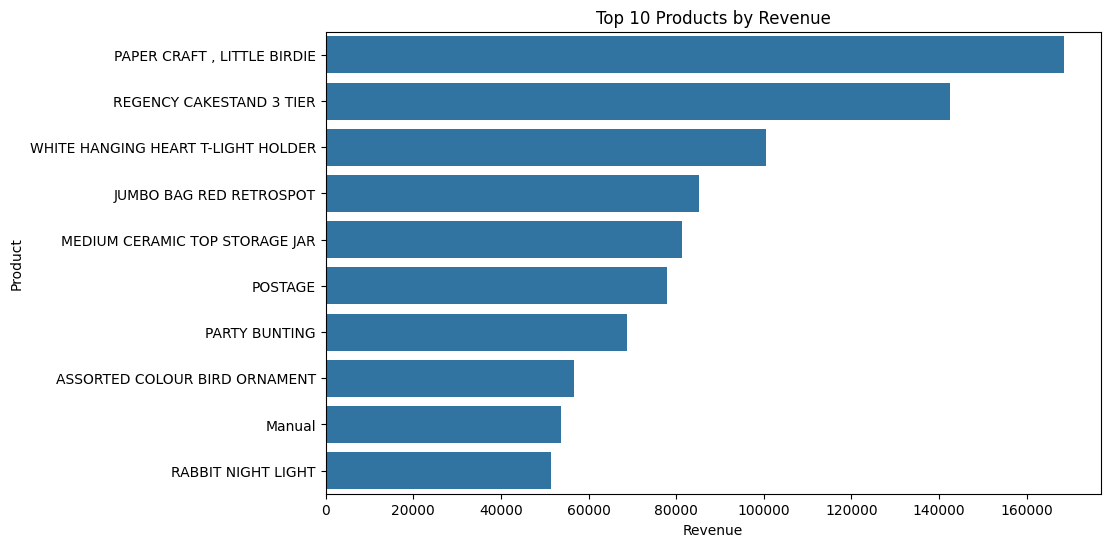

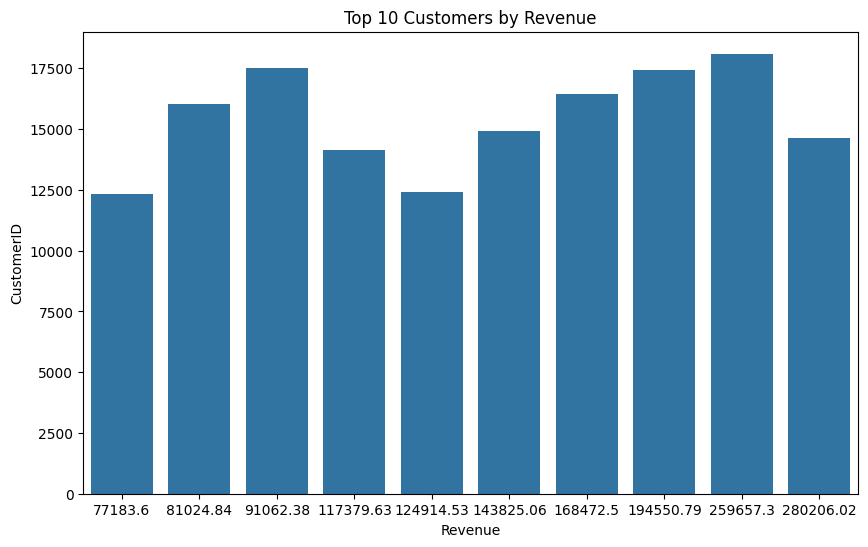

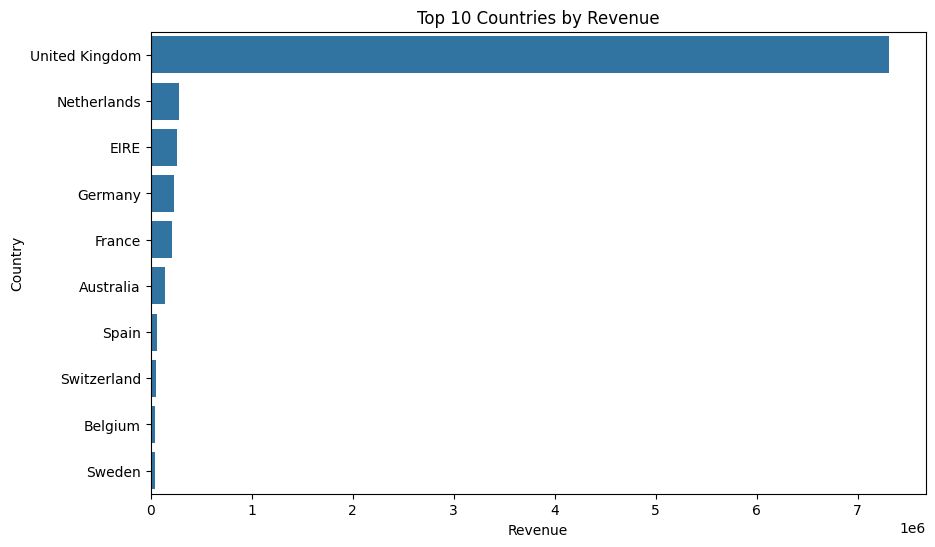

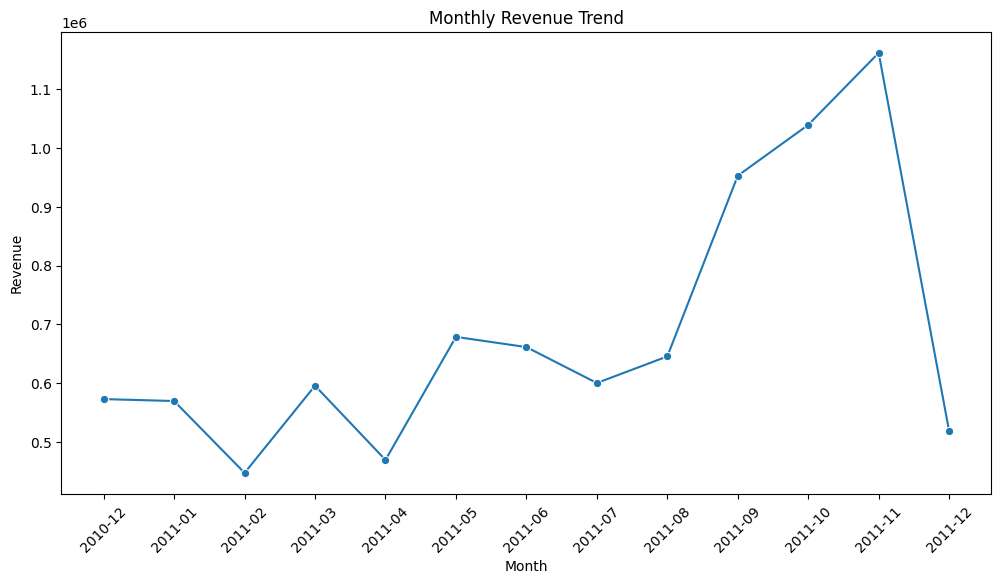

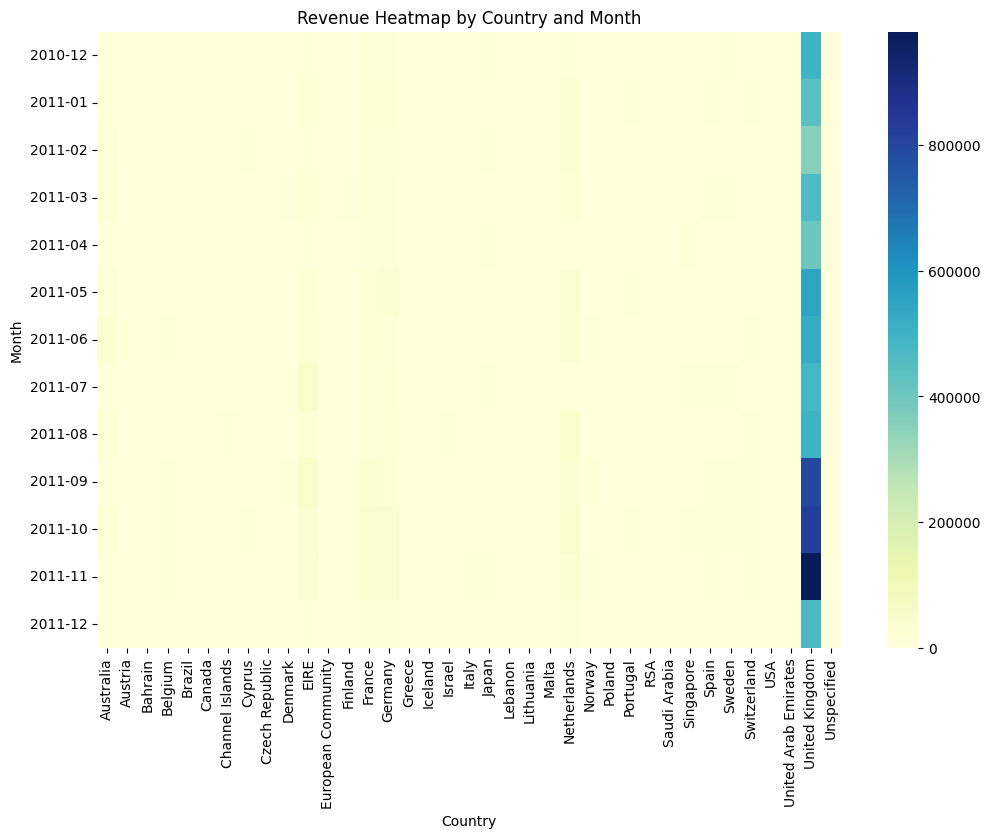

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 1. Top 10 products by revenue (Barplot)
plt.figure(figsize=(10,6))
sns.barplot(x='TotalRevenue', y='Description', data=top_products)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product')
plt.show()

# 2. Top 10 clients by revenue (Barplot)
plt.figure(figsize=(10,6))
sns.barplot(x='TotalRevenue', y='CustomerID', data=top_customers)
plt.title('Top 10 Customers by Revenue')
plt.xlabel('Revenue')
plt.ylabel('CustomerID')
plt.show()

# 3. Revenue by countries (Horizontal Barplot)
plt.figure(figsize=(10,6))
sns.barplot(x='TotalRevenue', y='Country', data=revenue_country)
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Country')
plt.show()

# 4. Monthly revenue dynamics (Lineplot)
plt.figure(figsize=(12,6))
sns.lineplot(x='Month', y='TotalRevenue', data=revenue_month, marker='o')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

# 5. Heatmap: revenue by country and month
monthly_country = sales_df.groupby([sales_df['InvoiceDate'].dt.strftime('%Y-%m'), 'Country'])['Revenue'].sum().unstack().fillna(0)
plt.figure(figsize=(12,8))
sns.heatmap(monthly_country, cmap='YlGnBu')
plt.title('Revenue Heatmap by Country and Month')
plt.xlabel('Country')
plt.ylabel('Month')
plt.show()


In [4]:
# Top 10 products by number of returns
top_returns = returns_df.groupby('Description')['Revenue'].count().sort_values(ascending=False).head(10)
display('Top 10 products by number of returns', top_returns)

print('\n')

# Revenue by country on refunds
returns_country = returns_df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)
display('Revenue by country on refunds', returns_country)

'Top 10 products by number of returns'

Description
REGENCY CAKESTAND 3 TIER              181
Manual                                175
POSTAGE                                97
JAM MAKING SET WITH JARS               86
Discount                               77
SET OF 3 CAKE TINS PANTRY DESIGN       73
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        53
RECIPE BOX PANTRY YELLOW DESIGN        47
WOOD 2 DRAWER CABINET WHITE FINISH     45
Name: Revenue, dtype: int64

'Revenue by country on refunds'

Country
European Community     -8.50
Saudi Arabia          -14.75
Austria               -44.36
Greece                -50.00
Czech Republic       -119.02
Poland               -121.51
Denmark              -187.20
Finland              -219.34
Malta                -220.12
Israel               -227.44
Name: Revenue, dtype: float64

In [5]:
sales_df.to_csv('../data/ecommerce_clean.csv', index=False)

## Business Insights
- The UK generates the highest revenue (≈ 80% of total sales)
- November and December show peak sales (holiday season effect)
- The top 5 products contribute ~5% of total revenue
- Average revenue per customer = $1898

In [6]:
df_sample = df.sample(5000, random_state=42)  # csv sample for hithub
df_sample.to_csv("../data/Ecommerce_Sample.csv", index=False)